# KNN normal prediction

In this notebook we want to see how well the KNN prediction performs if we do not update the model every day (i.e. we do a "normal" prediction).

In [1]:
import matplotlib

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from IPython.display import display

from data.get_50_highest_weights import get_sp_50_highest_weights_symbols
from data_preparation.ochlva_data import OCHLVAData
from utils.column_modifiers import target_generator
from utils.column_modifiers import feature_generator
from utils.column_modifiers import keep_columns
from utils.scorers import normalized_root_mean_square_error
from estimators.predictions import calculate_normal_prediction

C:\Users\michael.l.magnussen\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
matplotlib.use('nbAgg')

In [3]:
import matplotlib.pyplot as plt
from utils.visualizations import plot_true_and_prediction

Load the S&P 500 (as `^GSPC`) data

In [4]:
ochlva_data = OCHLVAData()

Load three other stocks: The stock weighted the most, the medium weighted stock and the lowest weighted stock (out of the 50 downloaded). 
We do this in order to get a better feeling of the model.

In [5]:
symbols = get_sp_50_highest_weights_symbols()

# Select symbols with high, medium and low weights
selected_symbols = (symbols.iloc[0], 
                    symbols.iloc[len(symbols)//2], 
                    symbols.iloc[-1])

for s in selected_symbols:
    ochlva_data.load_data(s)

For now, we will only be interested in training using the adjusted close values.

In [6]:
# Keep only 'Adj. Close' column
ochlva_data.transform(keep_columns, ['Adj. Close'], copy=False)

Next, we create the target values for the data.
The target columns will be shifted 7, 14 and 28 days with respect to 'Adj. Close'.

In [7]:
days = [7, 14, 28]
ochlva_data.transform(target_generator, 'Adj. Close', days, copy=False)

## Train and predict using normal prediction

<IPython.core.display.Javascript object>


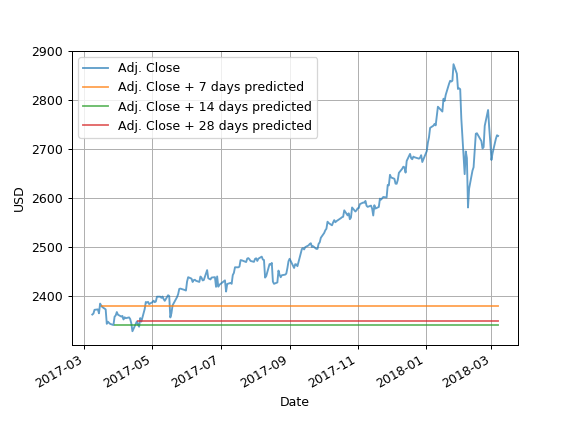

Normalized root mean squared error (averaged for the three predictions): 93.64816287598417
--------------------------------------------------------------------------------








<IPython.core.display.Javascript object>


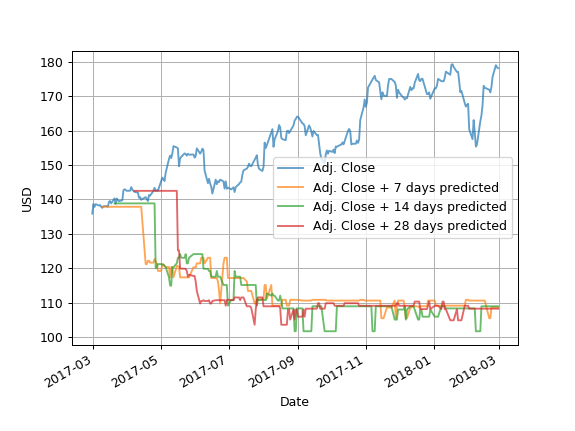

Normalized root mean squared error (averaged for the three predictions): 55.63588236827291
--------------------------------------------------------------------------------








<IPython.core.display.Javascript object>


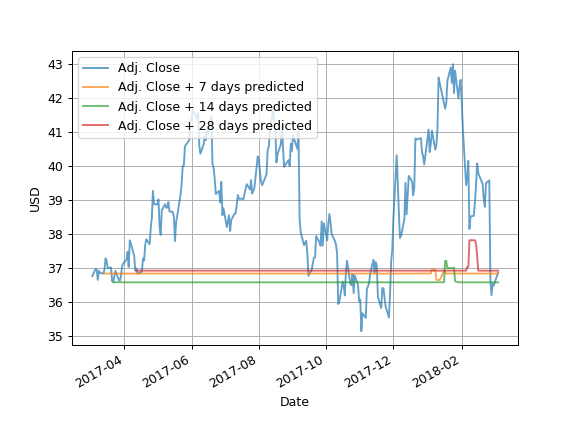

Normalized root mean squared error (averaged for the three predictions): 0.9698379098776635
--------------------------------------------------------------------------------








<IPython.core.display.Javascript object>


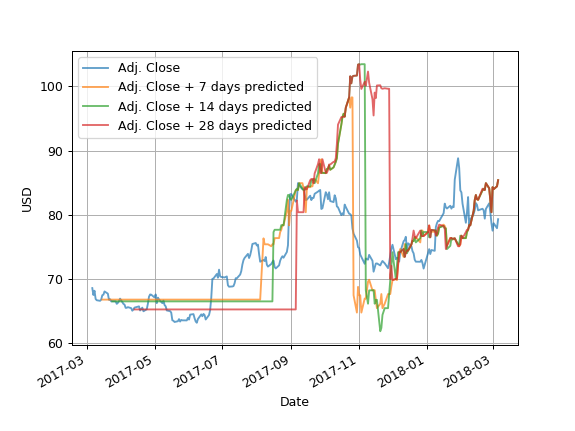

Normalized root mean squared error (averaged for the three predictions): 2.4219141938328037
--------------------------------------------------------------------------------








In [8]:
optimal_n = 1
optimal_features = 160

reg = neighbors.KNeighborsRegressor(n_neighbors=optimal_n)

for key in ochlva_data.transformed_data.keys():
    
    x = ochlva_data.transformed_data[key].\
        loc[:, ochlva_data.transformed_data[key].columns[:-len(days)]] 
    y = ochlva_data.transformed_data[key].\
        loc[:, ochlva_data.transformed_data[key].columns[-len(days):]]
        
    x_w_features = feature_generator(x, 'Adj. Close', optimal_features, 
                                     copy=True)   
    
    x_train, x_test, y_train, y_test = \
        train_test_split(x_w_features, y, shuffle=False, test_size=.2)
    
    # Obtain the day of prediction
    # I.e. for a column named x + 2 days, we would expect the two last rows
    # to contain nan
    prediction_days = y_test.isnull().sum()
    
    # NOTE: We refit the model here with the same architecture and training 
    #       data as we used in the rolling prediction
    #       This is beacuse the rolling prediction fits and predict target 
    #       by target
    y_pred = calculate_normal_prediction(reg,
                                         x_train,
                                         x_test,
                                         y_train,
                                         y_test, 
                                         prediction_days)
    
    # Plot the results
    _ = plot_true_and_prediction(x_test, y_pred, columns=['Adj. Close'], y_label='USD')
    plt.show()
    
    # As the first prediction is on the training set, we subtract 1 in the 
    # indexing to account for this
    # Calculate the normalized root mean squared error
    nrmse = normalized_root_mean_square_error(y_test, y_pred)
    
    print((f'Normalized root mean squared error (averaged for the three '
           f'predictions): {nrmse}'))
   
    print('-'*80)
    print('\n'*5)